In [6]:
# Loading Beat Annotation Data from oma.digital
# import omapy library
from omapy import oma
import pandas as pd
import json

# store your token in omacredentials.json
# {
#     'url': 'https://oma.digital/',
#     'token': 'the token value'
# }
with open("omacredentials.json","r") as credentials_file:
     oma_credentials = json.load(credentials_file)

# oma provides a handle to omapy API features via Login()
oma = oma.Login(oma_credentials["url"], oma_credentials["token"])

recording_ids = [173192]

sessions = []
for recording_id in recording_ids:
    recording = oma.recording(recording_id)
    recording_sessions = recording.get_annotation_sessions()
    for session in recording_sessions:
        sessions.append({'recording': recording.dictionary(), 'session': session})

sessions_table = pd.DataFrame(sessions)
sessions_table.head()


# make table nicer
# extract from dictionary fields.
sessions_table["recordingTitle"] = sessions_table["recording"].apply(lambda d : d["title"])
sessions_table["recordingId"] = sessions_table["recording"].apply(lambda d : d["id"])
sessions_table["sessionId"] = sessions_table["session"].apply(lambda d : d["id"])
sessions_table["sessionTitle"] = sessions_table["session"].apply(lambda d : d["title"])

sessions_table.head()

,recording,session,recordingTitle,recordingId,sessionId,sessionTitle
0,"{'id': 173192, 'title': 'Recording of 1969', '...","{'id': 173393, 'title': 'Upload of Boulez_LSO_...",Recording of 1969,173192,173393,Upload of Boulez_LSO_1969_Webern_op21-2_A3.csv
1,"{'id': 173192, 'title': 'Recording of 1969', '...","{'id': 173194, 'title': 'Upload of Boulez_LSO_...",Recording of 1969,173192,173194,Upload of Boulez_LSO_1969_Webern_op21-2_A1.txt
2,"{'id': 173192, 'title': 'Recording of 1969', '...","{'id': 173592, 'title': 'Upload of Boulez_LSO_...",Recording of 1969,173192,173592,Upload of Boulez_LSO_1969_Webern_op21-2_A4.txt


In [9]:
import numpy as np

def get_tempo_chart(session):
    annotations = session.dictionary()["annotations"]
    #print(annotations)
    #print("go", len(annotations))

    index = 0
    bar_numbers = np.zeros(len(annotations), dtype=int)
    bar_tempos = np.zeros(len(annotations))

    for current_annotation in range(len(annotations) - 1):
        #print("looping", current_annotation)
        annotation = annotations[current_annotation]
        # only take whole bars for now
        #print(annotation)
        if annotation["beatNumber"] != 1:
            continue

        bar_numbers[index] = annotation["barNumber"]
        current_bar_start = annotation["momentOfPerception"]
        next_bar_start = annotations[current_annotation + 1]["momentOfPerception"]
        duration = next_bar_start - current_bar_start
        # write back result
        # bar_durations[index] = duration
        if duration > 0:
            bar_tempos[index] = 1 / duration # or some other metric
        else:
            bar_tempos[index] = None

        index = index + 1

    # todo: strip array end

    return (bar_numbers[0:index], bar_tempos[0:index])


plots = []

for session_id in sessions_table["sessionId"].iteritems():
    session = oma.annotation_session(session_id[1])
    x, y = get_tempo_chart(session)
    plots.append({"session": session, "x": x, "y": y})
    


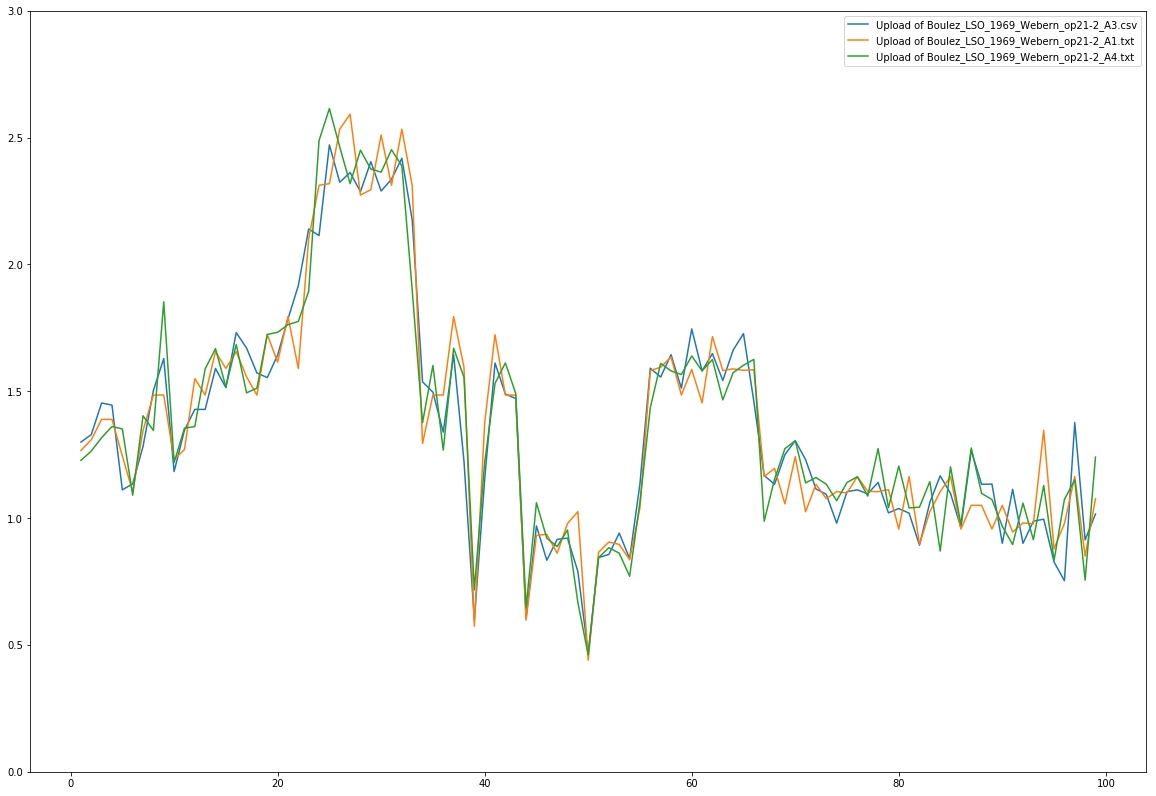

In [14]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.clear()
fig.set_figheight(14)
fig.set_figwidth(20)


for plot in plots:
    session_data = plot["session"].dictionary()
    # print(session_data["annotations"][0]["barNumber"], session_data["id"], session_data["title"])
    ax.plot(plot["x"], plot["y"], label=session_data["title"])

ax.set_ylim([0,3])
ax.legend()


